# Medical Reports NB

Recommendations Based on Use Case
Small Dataset (<10,000 samples):

Logistic Regression, SVM, or Random Forest: Simple models are likely sufficient.
Consider using TF-IDF or Bag-of-Words for feature extraction.
Medium Dataset (10,000 - 100,000 samples):

RNNs/LSTMs, CNNs, or Random Forest: Start exploring deep learning models if computational resources allow.
SVM could still be useful, depending on the text length and complexity.
Large Dataset (>100,000 samples):

Transformer-based models: Fine-tune a pre-trained model like BERT or RoBERTa.
Use deep learning architectures (CNNs, LSTMs) if you want to experiment with more customized models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [241]:
# 5 types of medical condtion

# digestive system diseases, 
# cardiovascular diseases, 
# neoplasms, 
# nervous system diseases,
# general pathological conditions.

In [209]:
df_train = pd.read_csv("data/train.dat", delimiter="\t", header=None, names=["label", "report"])

In [40]:
df_test = pd.read_csv("data/test.dat", delimiter="\t", header=None, names=["report"])

In [182]:
df_train.head()

label                                             report
0      4  Catheterization laboratory events and hospital...
1      5  Renal abscess in children. Three cases of rena...
2      2  Hyperplastic polyps seen at sigmoidoscopy are ...
3      5  Subclavian artery to innominate vein fistula a...
4      4  Effect of local inhibition of gamma-aminobutyr...

In [42]:
df_test.head()

report
0  Excision of limbal dermoids. We reviewed the c...
1  Bell's palsy. A diagnosis of exclusion. In cas...
2  Retained endobronchial foreign body removal fa...
3  Recurrent buccal space abscesses: a complicati...
4  Intracranial fibromatosis. Fibromatoses are un...

In [43]:
df_train

label                                             report
0          4  Catheterization laboratory events and hospital...
1          5  Renal abscess in children. Three cases of rena...
2          2  Hyperplastic polyps seen at sigmoidoscopy are ...
3          5  Subclavian artery to innominate vein fistula a...
4          4  Effect of local inhibition of gamma-aminobutyr...
...      ...                                                ...
14433      4  Quadricuspid aortic valve and aortic regurgita...
14434      1  Mammographic measurements before and after aug...
14435      1  Use of leukocyte-depleted platelet concentrate...
14436      2  Complications of Tenckhoff catheters post remo...
14437      3  Fatal or severely disabling cerebral infarctio...

[14438 rows x 2 columns]

In [48]:
# checking the labels

set(df_train.label.values)

{1, 2, 3, 4, 5}

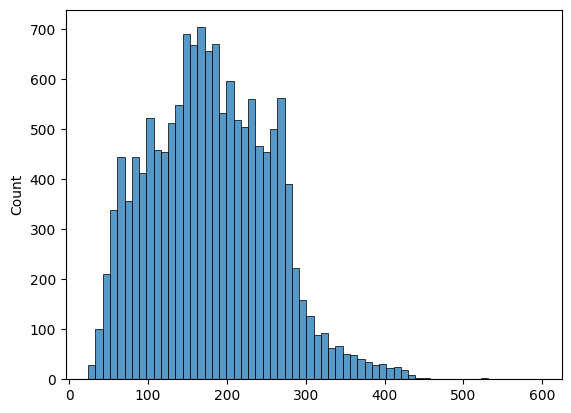

In [74]:
reviews_lenghts=[len(i.split()) for i in df_train['report']]
sns.histplot(reviews_lenghts);

### Data cleaning

In [20]:
#!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.6 MB/s eta 0:00:00


In [26]:
# When importing nltk for the first time, we need to also download a few built-in libraries

import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carlobarbini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/carlobarbini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/carlobarbini/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/carlobarbini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/carlobarbini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [210]:
from nltk.corpus import stopwords 
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize 

def clean (text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma=WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    cleaned = ' '.join(lemmatized) # Join back to a string
    return cleaned



In [211]:
# Apply to all texts
df_train['clean_report'] = df_train.report.apply(clean)

df_train.head()

label                                             report  \
0      4  Catheterization laboratory events and hospital...   
1      5  Renal abscess in children. Three cases of rena...   
2      2  Hyperplastic polyps seen at sigmoidoscopy are ...   
3      5  Subclavian artery to innominate vein fistula a...   
4      4  Effect of local inhibition of gamma-aminobutyr...   

                                        clean_report  
0  catheterization laboratory event hospital outc...  
1  renal abscess child three case renal abscess c...  
2  hyperplastic polyp seen sigmoidoscopy marker a...  
3  subclavian artery innominate vein fistula inse...  
4  effect local inhibition gamma aminobutyric aci...

### Baseline

In [65]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_bow = vectorizer.fit_transform(df_train.clean_report)

In [66]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate

cv_nb = cross_validate( MultinomialNB(), X_bow, df_train["label"], scoring = "accuracy")

baseline_accuracy = cv_nb['test_score'].mean()
baseline_accuracy

0.5813140047994304

In [58]:
print(f"Baseline accuracy with a multinomial Naive Bayes model is {round(baseline_accuracy, 2)}")

Baseline accuracy with a multinomial Naive Bayes model is 0.58


### LDA

In [229]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

data_vectorized = vectorizer.fit_transform(df_train['clean_report'])

lda_model = LatentDirichletAllocation(n_components=5)

lda_vectors = lda_model.fit_transform(data_vectorized)

In [235]:
example = [df_train.clean_report[0]]
example

['catheterization laboratory event hospital outcome direct angioplasty acute myocardial infarction assess safety direct infarct angioplasty without antecedent thrombolytic therapy catheterization laboratory hospital event assessed consecutively treated patient infarction involving left anterior descending n patient right n circumflex n coronary artery group patient similar age left anterior descending coronary artery year right coronary artery year circumflex coronary artery year patient multivessel disease left anterior descending coronary artery right coronary artery circumflex coronary artery patient initial grade antegrade flow left anterior descending coronary artery right coronary artery circumflex coronary artery cardiogenic shock present eight patient infarction left anterior descending coronary artery four infarction right coronary artery four infarction circumflex coronary artery major catheterization laboratory event cardioversion cardiopulmonary resuscitation dopamine intra

In [246]:
def print_topics(model, vectorizer):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-10 - 1:-1]])

In [247]:
print_topics(lda_model, vectorizer)

Topic 0:
[('cell', 5810.388511549812), ('patient', 4448.029994874109), ('case', 3440.831503242697), ('tumor', 2696.7641870155376), ('disease', 2415.536527820005), ('carcinoma', 2006.6304249320576), ('syndrome', 1775.5522775300983), ('infection', 1698.6473889060167), ('associated', 1496.5146690522351), ('antibody', 1381.0582499633056)]
Topic 1:
[('patient', 7170.080181727512), ('tumor', 2721.2089159903303), ('cancer', 1870.6673951144842), ('treatment', 1702.7948138921859), ('case', 1436.2690138833127), ('year', 1311.847967640438), ('lesion', 1288.4406974289373), ('clinical', 1255.63866516209), ('diagnosis', 1220.8243022710785), ('study', 1213.3712059520203)]
Topic 2:
[('patient', 13213.311998124875), ('artery', 3533.7831779493913), ('coronary', 2903.794790074312), ('ventricular', 2569.522316699409), ('year', 2308.6895780927807), ('left', 2172.9892737365567), ('group', 1942.658667284176), ('complication', 1898.0715962891672), ('one', 1827.519789056205), ('two', 1773.345705804894)]
Topic 

In [236]:
example_vectorized = vectorizer.transform(example)

lda_vectors = lda_model.transform(example_vectorized)

print("topic 0 :", lda_vectors[0][0])
print("topic 1 :", lda_vectors[0][1])
print("topic 2 :", lda_vectors[0][2])
print("topic 3 :", lda_vectors[0][3])
print("topic 4 :", lda_vectors[0][4])

topic 0 : 0.0012833434130515554
topic 1 : 0.0012849673746875765
topic 2 : 0.9948395599679388
topic 3 : 0.0012929781873461748
topic 4 : 0.0012991510569758868


In [245]:
example_pred = np.argmax(lda_vectors[0])
example_pred

2

In [248]:
df_train_lda = df_train.copy()
df_train_lda

label                                             report  \
0          3  Catheterization laboratory events and hospital...   
1          4  Renal abscess in children. Three cases of rena...   
2          1  Hyperplastic polyps seen at sigmoidoscopy are ...   
3          4  Subclavian artery to innominate vein fistula a...   
4          3  Effect of local inhibition of gamma-aminobutyr...   
...      ...                                                ...   
14433      3  Quadricuspid aortic valve and aortic regurgita...   
14434      0  Mammographic measurements before and after aug...   
14435      0  Use of leukocyte-depleted platelet concentrate...   
14436      1  Complications of Tenckhoff catheters post remo...   
14437      2  Fatal or severely disabling cerebral infarctio...   

                                            clean_report  
0      catheterization laboratory event hospital outc...  
1      renal abscess child three case renal abscess c...  
2      hyperplastic polyp seen sigmoidoscopy marker a...  
3      subclavian artery innominate vein fistula inse...  
4      effect local inhibition gamma aminobutyric aci...  
...                                                  ...  
14433  quadricuspid aortic valve aortic regurgitation...  
14434  mammographic measurement augmentation mammapla...  
14435  use leukocyte depleted platelet concentrate pr...  
14436  complication tenckhoff catheter post removal c...  
14437  fatal severely disabling cerebral infarction h...  

[14438 rows x 3 columns]

In [251]:
df_train_lda["vectorized"] = df_train_lda.clean_report.apply(lambda x: vectorizer.transform([x]))

In [258]:
df_train_lda["preds"] = df_train_lda.vectorized.apply(lambda x: np.argmax(lda_model.transform(x)[0]))

In [259]:
from sklearn.metrics import accuracy_score

In [260]:
df_train_lda

label                                             report  \
0          3  Catheterization laboratory events and hospital...   
1          4  Renal abscess in children. Three cases of rena...   
2          1  Hyperplastic polyps seen at sigmoidoscopy are ...   
3          4  Subclavian artery to innominate vein fistula a...   
4          3  Effect of local inhibition of gamma-aminobutyr...   
...      ...                                                ...   
14433      3  Quadricuspid aortic valve and aortic regurgita...   
14434      0  Mammographic measurements before and after aug...   
14435      0  Use of leukocyte-depleted platelet concentrate...   
14436      1  Complications of Tenckhoff catheters post remo...   
14437      2  Fatal or severely disabling cerebral infarctio...   

                                            clean_report  \
0      catheterization laboratory event hospital outc...   
1      renal abscess child three case renal abscess c...   
2      hyperplastic polyp seen sigmoidoscopy marker a...   
3      subclavian artery innominate vein fistula inse...   
4      effect local inhibition gamma aminobutyric aci...   
...                                                  ...   
14433  quadricuspid aortic valve aortic regurgitation...   
14434  mammographic measurement augmentation mammapla...   
14435  use leukocyte depleted platelet concentrate pr...   
14436  complication tenckhoff catheter post removal c...   
14437  fatal severely disabling cerebral infarction h...   

                                              vectorized  preds  
0      <Compressed Sparse Row sparse matrix of dtype ...      2  
1      <Compressed Sparse Row sparse matrix of dtype ...      0  
2      <Compressed Sparse Row sparse matrix of dtype ...      1  
3      <Compressed Sparse Row sparse matrix of dtype ...      2  
4      <Compressed Sparse Row sparse matrix of dtype ...      3  
...                                                  ...    ...  
14433  <Compressed Sparse Row sparse matrix of dtype ...      2  
14434  <Compressed Sparse Row sparse matrix of dtype ...      1  
14435  <Compressed Sparse Row sparse matrix of dtype ...      4  
14436  <Compressed Sparse Row sparse matrix of dtype ...      2  
14437  <Compressed Sparse Row sparse matrix of dtype ...      2  

[14438 rows x 5 columns]

In [261]:
accuracy_score(df_train_lda.label.values, df_train_lda.preds.values)

0.2244770743870342

### Random Forest

In [267]:
list(set(df_train.label.values))

[0, 1, 2, 3, 4]

In [268]:
y_val

4417     4
907      0
2859     4
5836     2
2715     0
        ..
8225     4
9143     2
12886    1
1210     3
8085     4
Name: label, Length: 2888, dtype: int64

In [271]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

tfidf_vectorizer = TfidfVectorizer(max_features=2000)  # You can adjust max_features as needed
X_tfidf = tfidf_vectorizer.fit_transform(df_train.clean_report)

X_train, X_val, y_train, y_val = train_test_split(X_tfidf, df_train.label, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=30, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)#, target_names=list(set(df_train.label.values)))

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


Accuracy: 0.4820
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62       647
           1       0.37      0.28      0.32       315
           2       0.40      0.33      0.36       370
           3       0.58      0.60      0.59       621
           4       0.39      0.44      0.41       935

    accuracy                           0.48      2888
   macro avg       0.47      0.45      0.46      2888
weighted avg       0.48      0.48      0.48      2888



### Tokens and embeddings

In [75]:
from transformers import AutoTokenizer

In [76]:
tokenizer = AutoTokenizer.from_pretrained( "prajjwal1/bert-tiny", padding_side="right")


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/Users/carlobarbini/.pyenv/versions/3.10.6/envs/doc-gpt-env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


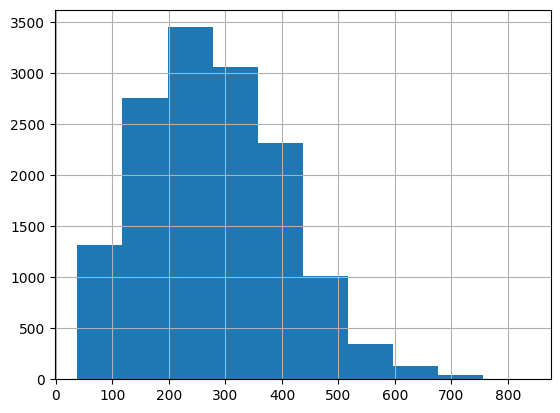

In [80]:
df_train["tokenized"] = df_train["report"].map(lambda x: tokenizer(x)["input_ids"])

df_train["len_tokenized"] = df_train["tokenized"].map(lambda x: len(x))

df_train["len_tokenized"].hist();

In [214]:
tokenized_tensors = tokenizer(df_train['report'].to_list(),
                              max_length=500, padding = "max_length", truncation = True, return_tensors="tf")

In [85]:
tokenized_tensors["input_ids"].shape

TensorShape([14438, 500])

In [82]:
from transformers import TFAutoModel 

In [83]:
tiny_bert = TFAutoModel.from_pretrained("prajjwal1/bert-tiny", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [84]:
embeddings = tiny_bert.predict(tokenized_tensors["input_ids"])


452/452 [==============================] - 50s 108ms/step


In [86]:
embeddings[0].shape

(14438, 500, 128)

In [87]:
embeddings.last_hidden_state.shape

(14438, 500, 128)

In [88]:
X = embeddings.last_hidden_state[:,0,:]
X.shape

(14438, 128)

### DNN

In [89]:
from sklearn.model_selection import train_test_split

In [104]:
# ohe the labels

from sklearn.preprocessing import OneHotEncoder

In [105]:
y = df_train[["label"]]

In [106]:
y = OneHotEncoder(sparse_output=False).fit_transform(y)

In [108]:
y = pd.DataFrame(y)
y

0    1    2    3    4
0      0.0  0.0  0.0  1.0  0.0
1      0.0  0.0  0.0  0.0  1.0
2      0.0  1.0  0.0  0.0  0.0
3      0.0  0.0  0.0  0.0  1.0
4      0.0  0.0  0.0  1.0  0.0
...    ...  ...  ...  ...  ...
14433  0.0  0.0  0.0  1.0  0.0
14434  1.0  0.0  0.0  0.0  0.0
14435  1.0  0.0  0.0  0.0  0.0
14436  0.0  1.0  0.0  0.0  0.0
14437  0.0  0.0  1.0  0.0  0.0

[14438 rows x 5 columns]

In [109]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [110]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

input_shape = (128,)

dense_model = Sequential([
    Dense(256, activation='relu', input_shape=input_shape),
    Flatten(),
    Dense(5, activation='softmax')
])

dense_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

dense_model.fit(X_train, y_train, validation_split=0.2, epochs=20)

dense_model.evaluate(X_val, y_val)

Epoch 1/20


/Users/carlobarbini/.pyenv/versions/3.10.6/envs/doc-gpt-env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.3956 - loss: 1.4184 - val_accuracy: 0.4807 - val_loss: 1.2271
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.4837 - loss: 1.2191 - val_accuracy: 0.4674 - val_loss: 1.2388
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - accuracy: 0.4951 - loss: 1.1896 - val_accuracy: 0.4960 - val_loss: 1.2193
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - accuracy: 0.5060 - loss: 1.1877 - val_accuracy: 0.4921 - val_loss: 1.1863
Epoch 5/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.5036 - loss: 1.1608 - val_accuracy: 0.4975 - val_loss: 1.2091
Epoch 6/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - accuracy: 0.5327 - loss: 1.1306 - val_accuracy: 0.5178 - val_loss: 1.1718
Epoch 7/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - accuracy: 0.5269 - loss: 1.1280 - val_accuracy: 0.5000 - val_loss: 1.1883
Epoch 8/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.5479 - loss: 1.1030 - val_accurac

[1.2100706100463867, 0.4974607527256012]

### RNNs

In [277]:
!pip install gensim

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 48.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 36.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [278]:
from gensim.models import Word2Vec


In [292]:
len(df_train)

14438

In [293]:
X_train = [x.split() for x in df_train[:11000].clean_report.values.tolist()]
X_train

[['catheterization',
  'laboratory',
  'event',
  'hospital',
  'outcome',
  'direct',
  'angioplasty',
  'acute',
  'myocardial',
  'infarction',
  'assess',
  'safety',
  'direct',
  'infarct',
  'angioplasty',
  'without',
  'antecedent',
  'thrombolytic',
  'therapy',
  'catheterization',
  'laboratory',
  'hospital',
  'event',
  'assessed',
  'consecutively',
  'treated',
  'patient',
  'infarction',
  'involving',
  'left',
  'anterior',
  'descending',
  'n',
  'patient',
  'right',
  'n',
  'circumflex',
  'n',
  'coronary',
  'artery',
  'group',
  'patient',
  'similar',
  'age',
  'left',
  'anterior',
  'descending',
  'coronary',
  'artery',
  'year',
  'right',
  'coronary',
  'artery',
  'year',
  'circumflex',
  'coronary',
  'artery',
  'year',
  'patient',
  'multivessel',
  'disease',
  'left',
  'anterior',
  'descending',
  'coronary',
  'artery',
  'right',
  'coronary',
  'artery',
  'circumflex',
  'coronary',
  'artery',
  'patient',
  'initial',
  'grade',
  

In [294]:
X_test = [x.split() for x in df_train[11000:].clean_report.values.tolist()]
X_test

[['testicular',
  'calcification',
  'neoplasia',
  'patient',
  'treated',
  'subfertility',
  'subfertile',
  'male',
  'history',
  'left',
  'cryptorchism',
  'underwent',
  'scrotal',
  'ultrasound',
  'revealed',
  'stippled',
  'calcification',
  'without',
  'associated',
  'mass',
  'right',
  'testicle',
  'six',
  'month',
  'later',
  'regimen',
  'clomiphene',
  'citrate',
  'testicular',
  'tumor',
  'became',
  'palpable',
  'sonographically',
  'confirmed',
  'surrounding',
  'calcification',
  'testicular',
  'calcification',
  'commonly',
  'associated',
  'benign',
  'condition',
  'review',
  'literature',
  'regarding',
  'relationship',
  'neoplasm',
  'significance',
  'ultrasonic',
  'finding',
  'furthermore',
  'sixth',
  'reported',
  'case',
  'testicular',
  'tumor',
  'developing',
  'hormonal',
  'treatment',
  'oligospermia',
  'although',
  'case',
  'may',
  'circumstantial',
  'closer',
  'surveillance',
  'screening',
  'ultrasound',
  'may',
  'indi

In [295]:
word2vec = Word2Vec(sentences=X_train)


In [296]:

def embed_sentence(word2vec, sentence):
    # $CHALLENGIFY_BEGIN
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)


In [297]:
def embedding(word2vec, sentences):
    # $CHALLENGIFY_BEGIN
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed
    # $CHALLENGIFY_END
    
X_train_embedded = embedding(word2vec, X_train)
X_test_embedded = embedding(word2vec, X_test)

In [298]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_embedded, dtype='float32', padding='post')
X_test_pad = pad_sequences(X_test_embedded, dtype='float32', padding='post')

In [300]:
X_train_pad.shape

(11000, 377, 100)

In [305]:
X_train_pad.shape

(11000, 377, 100)

In [312]:
from tensorflow.keras import Sequential, layers

model = Sequential()

#model.add(layers.Masking(mask_value=-1., input_shape=(X_train_pad.shape)))

model.add(layers.Masking(mask_value=-1., input_shape=(X_train_pad.shape[1], X_train_pad.shape[2])))

#model.add(layers.GRU(units=20, activation='tanh', return_sequences=True))
model.add(layers.GRU(units=20, activation='tanh'))

model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_6 (Masking)             │ (None, 377, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 20)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,585 (29.63 KB)

 Trainable params: 7,585 (29.63 KB)

 Non-trainable params: 0 (0.00 B)

In [313]:
y_train = df_train[:11000].label
y_train.shape

(11000,)

In [315]:
%%time

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train_pad, y_train,
          epochs=15,
          batch_size=256,
          verbose=1,
          callbacks = [es],
          validation_split=0.2)

Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.3075 - loss: 1.5540 - val_accuracy: 0.3382 - val_loss: 1.5314
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.3241 - loss: 1.5424 - val_accuracy: 0.3382 - val_loss: 1.5317
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.3245 - loss: 1.5420 - val_accuracy: 0.3382 - val_loss: 1.5299
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.3251 - loss: 1.5407 - val_accuracy: 0.3382 - val_loss: 1.5303
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.3266 - loss: 1.5434 - val_accuracy: 0.3382 - val_loss: 1.5281
Epoch 6/15
18/35 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.3278 - loss: 1.5417

KeyboardInterrupt: 

### Transformers

In [111]:
#from transformers import BertTokenizer, TFBertForSequenceClassification
#from tensorflow.keras.optimizers import Adam

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# Compile model
#optimizer = Adam(learning_rate=3e-5)
#model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])


In [112]:
from transformers import TFAutoModelForSequenceClassification

In [113]:
bert_tiny_2 = TFAutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [183]:
df_train_small = df_train[:5000]
df_train_small

label                                             report
0         4  Catheterization laboratory events and hospital...
1         5  Renal abscess in children. Three cases of rena...
2         2  Hyperplastic polyps seen at sigmoidoscopy are ...
3         5  Subclavian artery to innominate vein fistula a...
4         4  Effect of local inhibition of gamma-aminobutyr...
...     ...                                                ...
4995      2  Effect of indomethacin on gastric mucosal bloo...
4996      3  Verbal memory impairment correlates with hippo...
4997      3  Surgical management of oculomotor nerve palsy ...
4998      4  Hydroxyethyl starch pretreatment in bacteremic...
4999      4  Femoropopliteal angioplasty. Factors influenci...

[5000 rows x 2 columns]

In [217]:
split_ratio = 0.2
index_split = round(len(df_train) * (1-split_ratio))
index_split

11550

In [222]:
# bert sets labels from 0 to 4 if there are 5 so we need to turn the data labels also to this range

df_train["label"] = df_train.label.apply(lambda x : x -1)

In [223]:
set(df_train.label.values)

{0, 1, 2, 3, 4}

In [224]:
X_train = tokenized_tensors["input_ids"][:index_split]
X_val = tokenized_tensors["input_ids"][index_split:]
y_train = df_train["label"][:index_split]
y_val = df_train["label"][index_split:]

In [225]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

(TensorShape([11550, 500]), TensorShape([2888, 500]), (11550,), (2888,))

In [194]:
import tensorflow as tf

In [170]:
#!pip install tf_keras

In [171]:
#!export TF_USE_LEGACY_KERAS=True


In [172]:
#y_train = OneHotEncoder(sparse_output=False).fit_transform(pd.DataFrame(y_train))
#y_train

In [173]:
#y_val = OneHotEncoder(sparse_output=False).fit_transform(pd.DataFrame(y_val))
#y_val

In [195]:
y_train.shape, y_val.shape

((4000,), (1000,))

In [226]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
fast_model = TFAutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", from_pt = True, 
                                                                  num_labels=5)

fast_model.compile(optimizer= "adam", metrics= "accuracy", loss="sparse_categorical_crossentropy")
fast_model.fit(X_train, y_train, validation_split=0.1, batch_size=64, epochs=5)

fast_model.evaluate(X_val, y_val)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
145/145 [==============================] - 108s 736ms/step - loss: 7.6554 - accuracy: 0.2031 - val_loss: 7.2441 - val_accuracy: 0.1714
Epoch 2/5
145/145 [==============================] - 107s 735ms/step - loss: 2.7442 - accuracy: 0.3158 - val_loss: 1.6094 - val_accuracy: 0.3450
Epoch 3/5
145/145 [==============================] - 107s 738ms/step - loss: 1.6094 - accuracy: 0.3182 - val_loss: 1.6094 - val_accuracy: 0.3450
Epoch 4/5
145/145 [==============================] - 106s 731ms/step - loss: 1.6094 - accuracy: 0.3187 - val_loss: 1.6094 - val_accuracy: 0.3450
Epoch 5/5
91/91 [==============================] - 11s 126ms/step - loss: 1.6094 - accuracy: 0.3456


[1.6094365119934082, 0.34556785225868225]

In [227]:
print(f"Accuracy with a fine-tuned bert tiny model is {round(fast_model.evaluate(X_val, y_val)[1], 2)}")

91/91 [==============================] - 11s 125ms/step - loss: 1.6094 - accuracy: 0.3456
Accuracy with a fine-tuned bert tiny model is 0.35
